machinedesign_7525_genx_jet_promo_0.avif
# Aircraft Engine Failure Prediction using **LSTM**


### Description
Prognostics and health management is an important topic in industry for predicting state of assets to avoid downtime and failures. This data set is the Kaggle version of the very well known public data set for asset degradation modeling from NASA. It includes Run-to-Failure simulated data from turbo fan jet engines.

Engine degradation simulation was carried out using C-MAPSS. Four different were sets simulated under different combinations of operational conditions and fault modes. Records several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.

### Experimental Scenario
Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The Dataset contains three types of files:
1. PM_train.txt (Training data) --> It is the aircraft engine run-to-failure data.
2. PM_test.txt (Testing data) --> It is the aircraft engine operating data without failure events recorded.
3. PM_truth.txt (Ground truth data) --> It contains the information of true remaining cycles for each engine in the testing data.

Feature Information:
1. Feature 'id' has values from 1 to hundred. These values correspond to 100 engines
2. Feature 'cycle' has values of number of cycles over of engine
3. The last cycle for 'id' is where that engine failed
4. Features 'setting1', 'setting2', 'setting3' are three different setting of engines
4. 's1' to 's23' are sensor data of 23 sensors

## Problem Statement


The objective of this study is to solve a problem of classification where we will predict whether a given Aircraft Engine will fail within next 30 days or not.

Remaining useful life (RUL) of train data is not provided. So it was generated using given information.

Keras sequencial model with two LSTM layers and adam optimizer is used.

## Feature engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df_train = pd.read_csv(
  '../Project#6/PM_train.txt', sep = ' ', header = None
).drop([26, 27], axis = 1)
df_train.shape

(20631, 26)

---

Columns 26, 27 has no data. So we delete them.

---

In [3]:
col_names = [
    'id',
    'cycle',
    'setting1',
    'setting2',
    'setting3',
    's1',
    's2',
    's3',
    's4',
    's5',
    's6',
    's7',
    's8',
    's9',
    's10',
    's11',
    's12',
    's13',
    's14',
    's15',
    's16',
    's17',
    's18',
    's19',
    's20',
    's21'
    ]
df_train.columns = col_names
df_train

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [4]:
df_train.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400



---


1.  Variable 'id' has values from 1 to hundred. These values correspond to 100 engines.
2.  Number of cycles over of engine is given by 'cycle'
1.  The last cycle for a id is where that engine failed. We can see the engine operated between 1 and 362 cycles.

---



In [5]:
df_test = pd.read_csv(
  '../Project#6/PM_test.txt', sep = ' ', header = None
).drop([26, 27], axis = 1)
df_test.shape

(13096, 26)

---

Columns 26, 27 has no data. So we also delete them.

---

In [6]:
df_test.columns = col_names
df_test

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [7]:
df_test.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,1.309600e+04,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,5.186700e+02,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,6.014263e-11,0.400899,5.003274,6.688309,2.671743e-12,...,0.559627,0.056934,10.188605,0.029009,8.823140e-15,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,5.186700e+02,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,0.000000,0.000000,100.0,5.186700e+02,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,5.186700e+02,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,5.186700e+02,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


---


1.  Variable 'id' has values from 1 to hundred. These values correspond to 100 engines.
2.  Number of cycles over of engine is given by 'cycle'
1.  The last cycle for a id is where that engine failed. We can see the engine operated between 1 and 303 cycles.
---



In [8]:
df_truth = pd.read_csv(
  '../Project#6/PM_truth.txt', sep = ' ', header = None).drop([1], axis = 1)
df_truth.shape

(100, 1)

---

Column 1 has no data. So we delete them.

---

In [9]:
df_truth.columns = ['more']
df_truth['id'] = df_truth.index + 1
df_truth.head(10)

,more,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
5,93,6
6,91,7
7,95,8
8,111,9
9,96,10


In [10]:
rul = pd.DataFrame(df_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [11]:
df_truth['rtf'] = df_truth['more'] + rul['max']
df_truth.head()


,more,id,rtf
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [12]:
df_truth.drop('more', axis = 1, inplace = True)
df_truth.head()


,id,rtf
0,1,143
1,2,147
2,3,195
3,4,188
4,5,189


In [13]:
def correlation(data):
    corr_mat = data.corr()
    return corr_mat

In [14]:
corr = correlation(df_train)
corr

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
id,1.000000,0.078753,-0.017895,-0.006197,NaN,NaN,0.014133,0.012621,0.026116,NaN,...,-0.031882,0.044230,-0.059473,0.022486,NaN,0.013513,NaN,NaN,-0.020589,-0.016465
cycle,0.078753,1.000000,-0.004527,0.016132,NaN,NaN,0.549898,0.543947,0.624577,NaN,...,-0.611354,0.477523,0.370324,0.588676,NaN,0.566995,NaN,NaN,-0.583597,-0.585923
setting1,-0.017895,-0.004527,1.000000,0.011660,NaN,NaN,0.009030,-0.005651,0.009544,NaN,...,-0.001491,0.002318,-0.004469,0.007652,NaN,0.002599,NaN,NaN,-0.005713,-0.014559
setting2,-0.006197,0.016132,0.011660,1.000000,NaN,NaN,0.007266,0.009068,0.014673,NaN,...,-0.010923,0.018156,-0.006310,0.014156,NaN,0.012280,NaN,NaN,-0.010554,-0.007846
setting3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s2,0.014133,0.549898,0.009030,0.007266,NaN,NaN,1.000000,0.602610,0.714949,NaN,...,-0.724578,0.661792,0.179752,0.675975,NaN,0.629886,NaN,NaN,-0.661841,-0.668050
s3,0.012621,0.543947,-0.005651,0.009068,NaN,NaN,0.602610,1.000000,0.678413,NaN,...,-0.680307,0.600963,0.237137,0.639921,NaN,0.600017,NaN,NaN,-0.625941,-0.633901
s4,0.026116,0.624577,0.009544,0.014673,NaN,NaN,0.714949,0.678413,1.000000,NaN,...,-0.815591,0.745158,0.190748,0.758459,NaN,0.703499,NaN,NaN,-0.748067,-0.745193
s5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

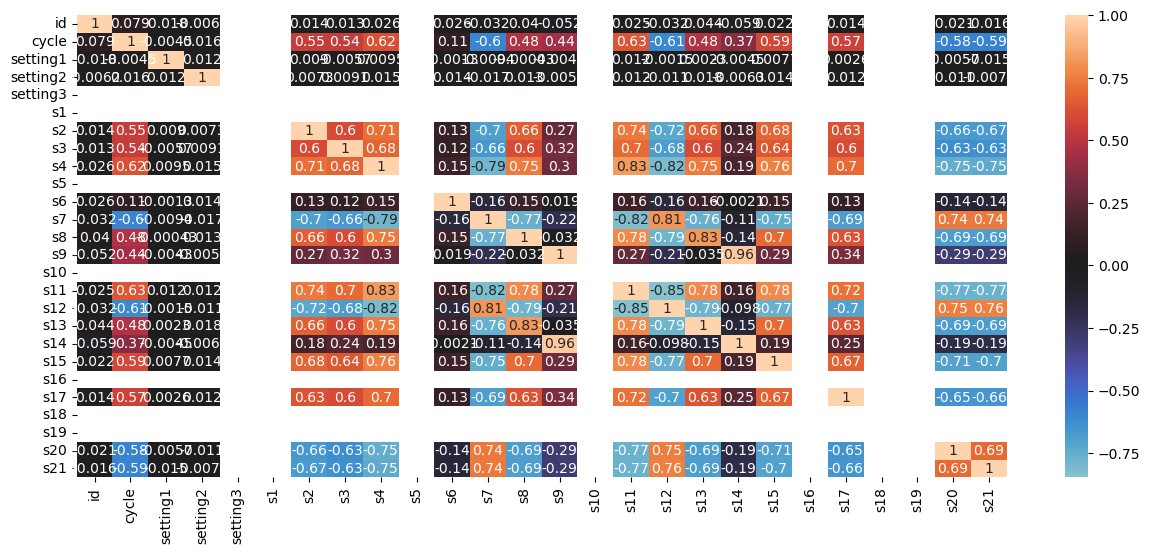

In [15]:
plt.figure(figsize = (15, 6))
sns.heatmap(data = corr, annot = True, center = 0)

In [16]:
df_test = df_test.merge(df_truth, on = ['id'], how = 'left')
df_test

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rtf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,143
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,143
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,143
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,143
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,218
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,218
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,218
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,218


In [17]:
df_train['rul'] = df_train.groupby(['id'])['cycle'].transform(max) - df_train['cycle']
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


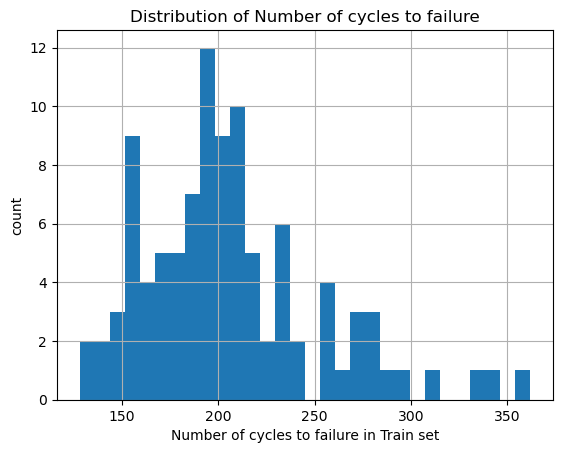

In [18]:
df_train['id'].value_counts().hist(bins=30)
plt.title('Distribution of Number of cycles to failure')
plt.ylabel('count')
plt.xlabel('Number of cycles to failure in Train set');
plt.show()



---


1. The distribution is somewhat bell shaped
2. Around 12 engines failed after 200 cycles, which is maximum in distribution
3. Very few engines failed after 300 cycles


---


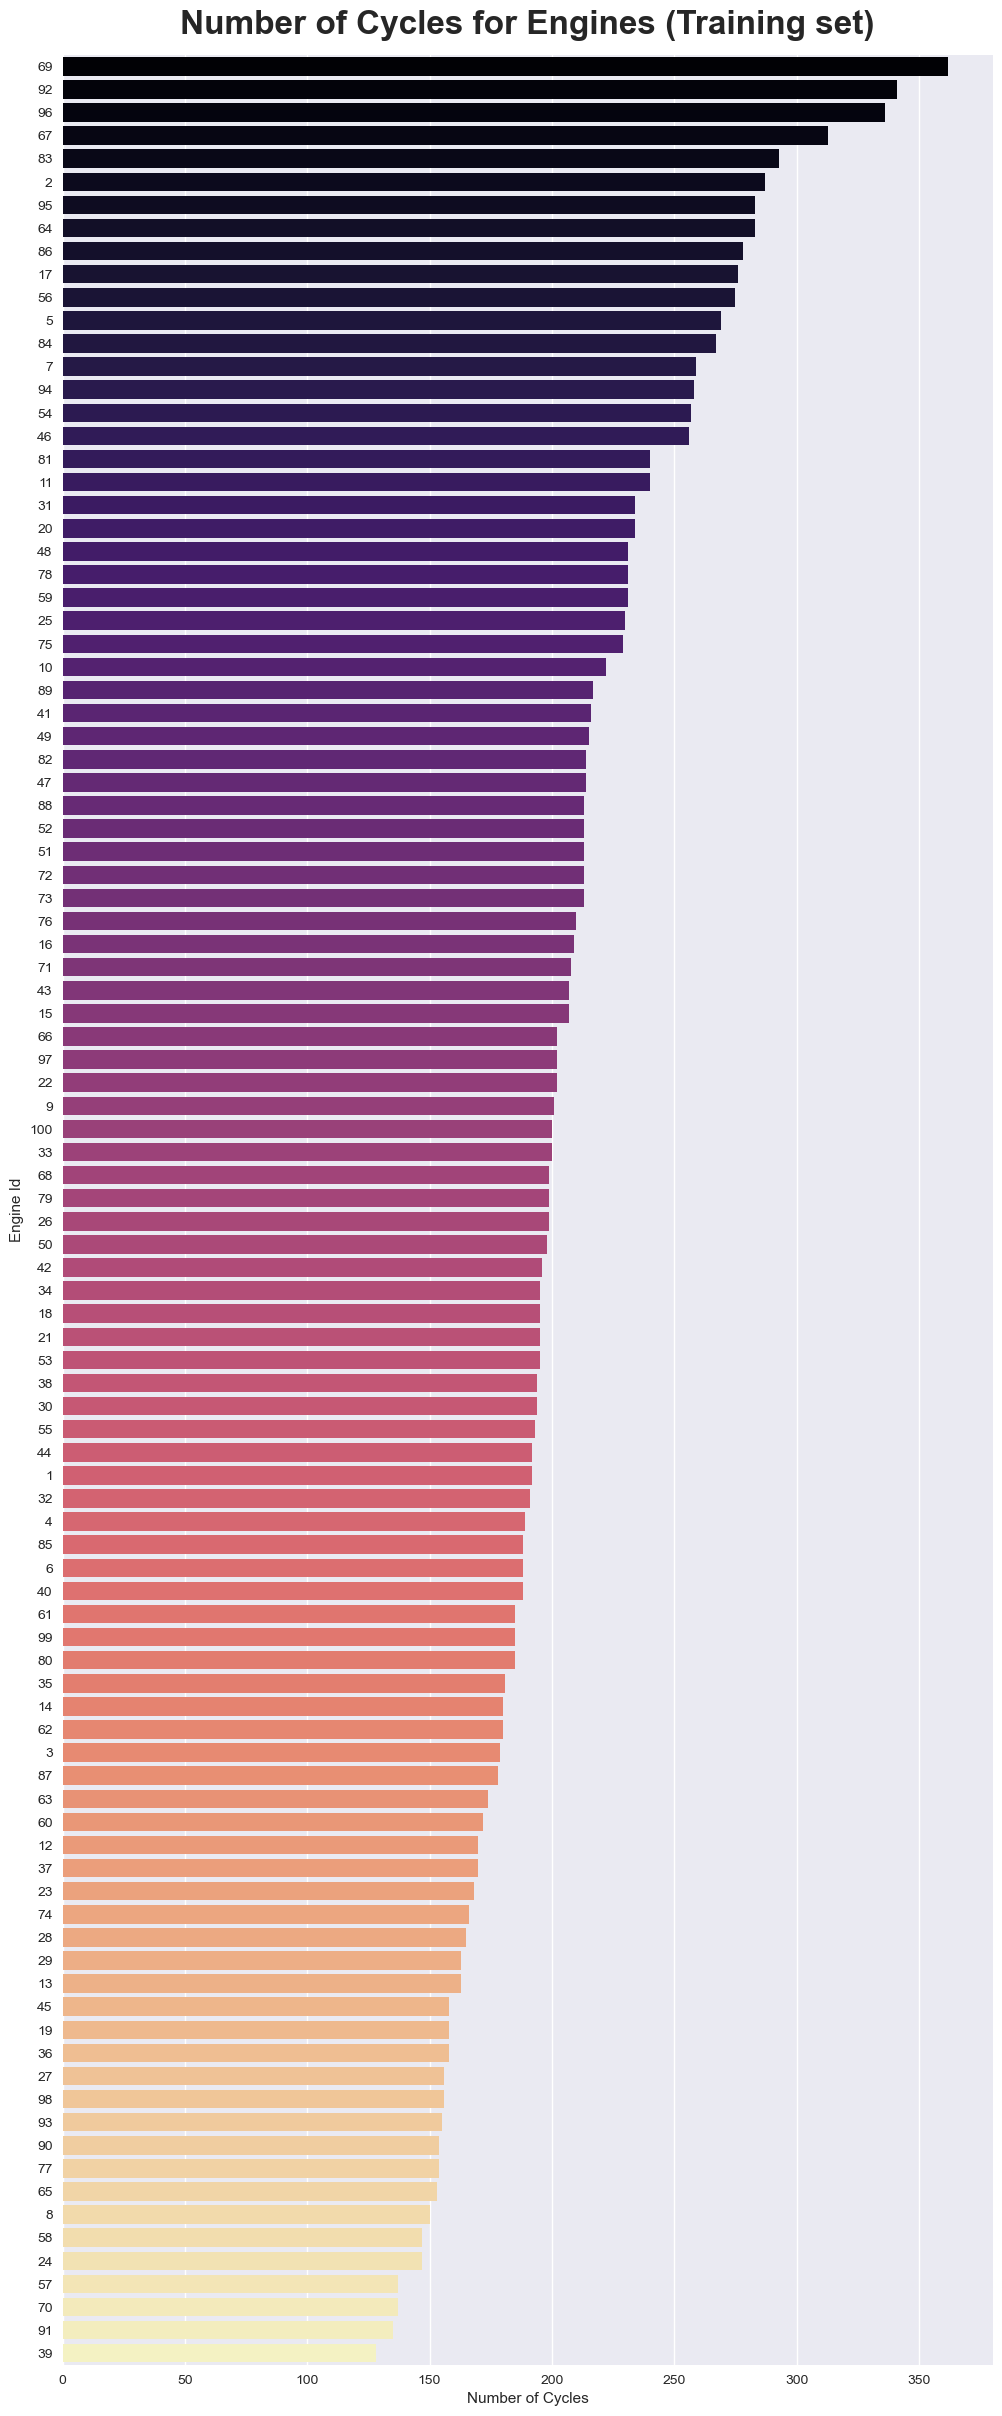

In [19]:
cnt_train = df_train[["id", "cycle"]].groupby("id").max().sort_values(by="cycle", ascending=False)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.cycle.values)

plt.style.use("seaborn")
plt.figure(figsize=(12, 30))
sns.barplot(x=list(cnt_val), y=list(cnt_ind), palette='magma')
plt.xlabel('Number of Cycles')
plt.ylabel('Engine Id')
plt.title('Number of Cycles for Engines (Training set)', fontweight='bold', fontsize=24, pad=15)

plt.show()




---

1. Engine # 69 has value of 362 cicles. It's a maximum value
2. Engine # 39 has value of 130 cicles. It's a minimum value

---



In [20]:
df_test['rul'] = df_test['rtf'] - df_test['cycle']
df_test.drop('rtf', axis = 1, inplace = True)
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


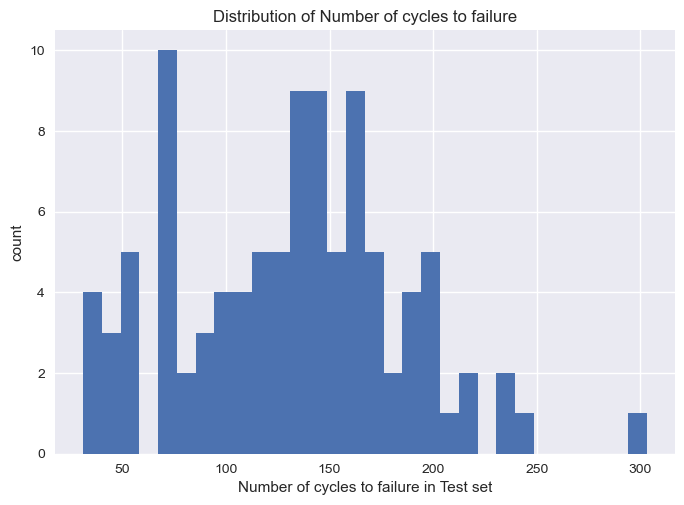

In [21]:
df_test['id'].value_counts().hist(bins=30)
plt.title('Distribution of Number of cycles to failure')
plt.ylabel('count')
plt.xlabel('Number of cycles to failure in Test set');
plt.show()



---


1. The distribution is somewhat bell shaped
2. Around 10 engines failed after 70 cycles, which is maximum in distribution
3. Very few engines failed after 300 cycles


---


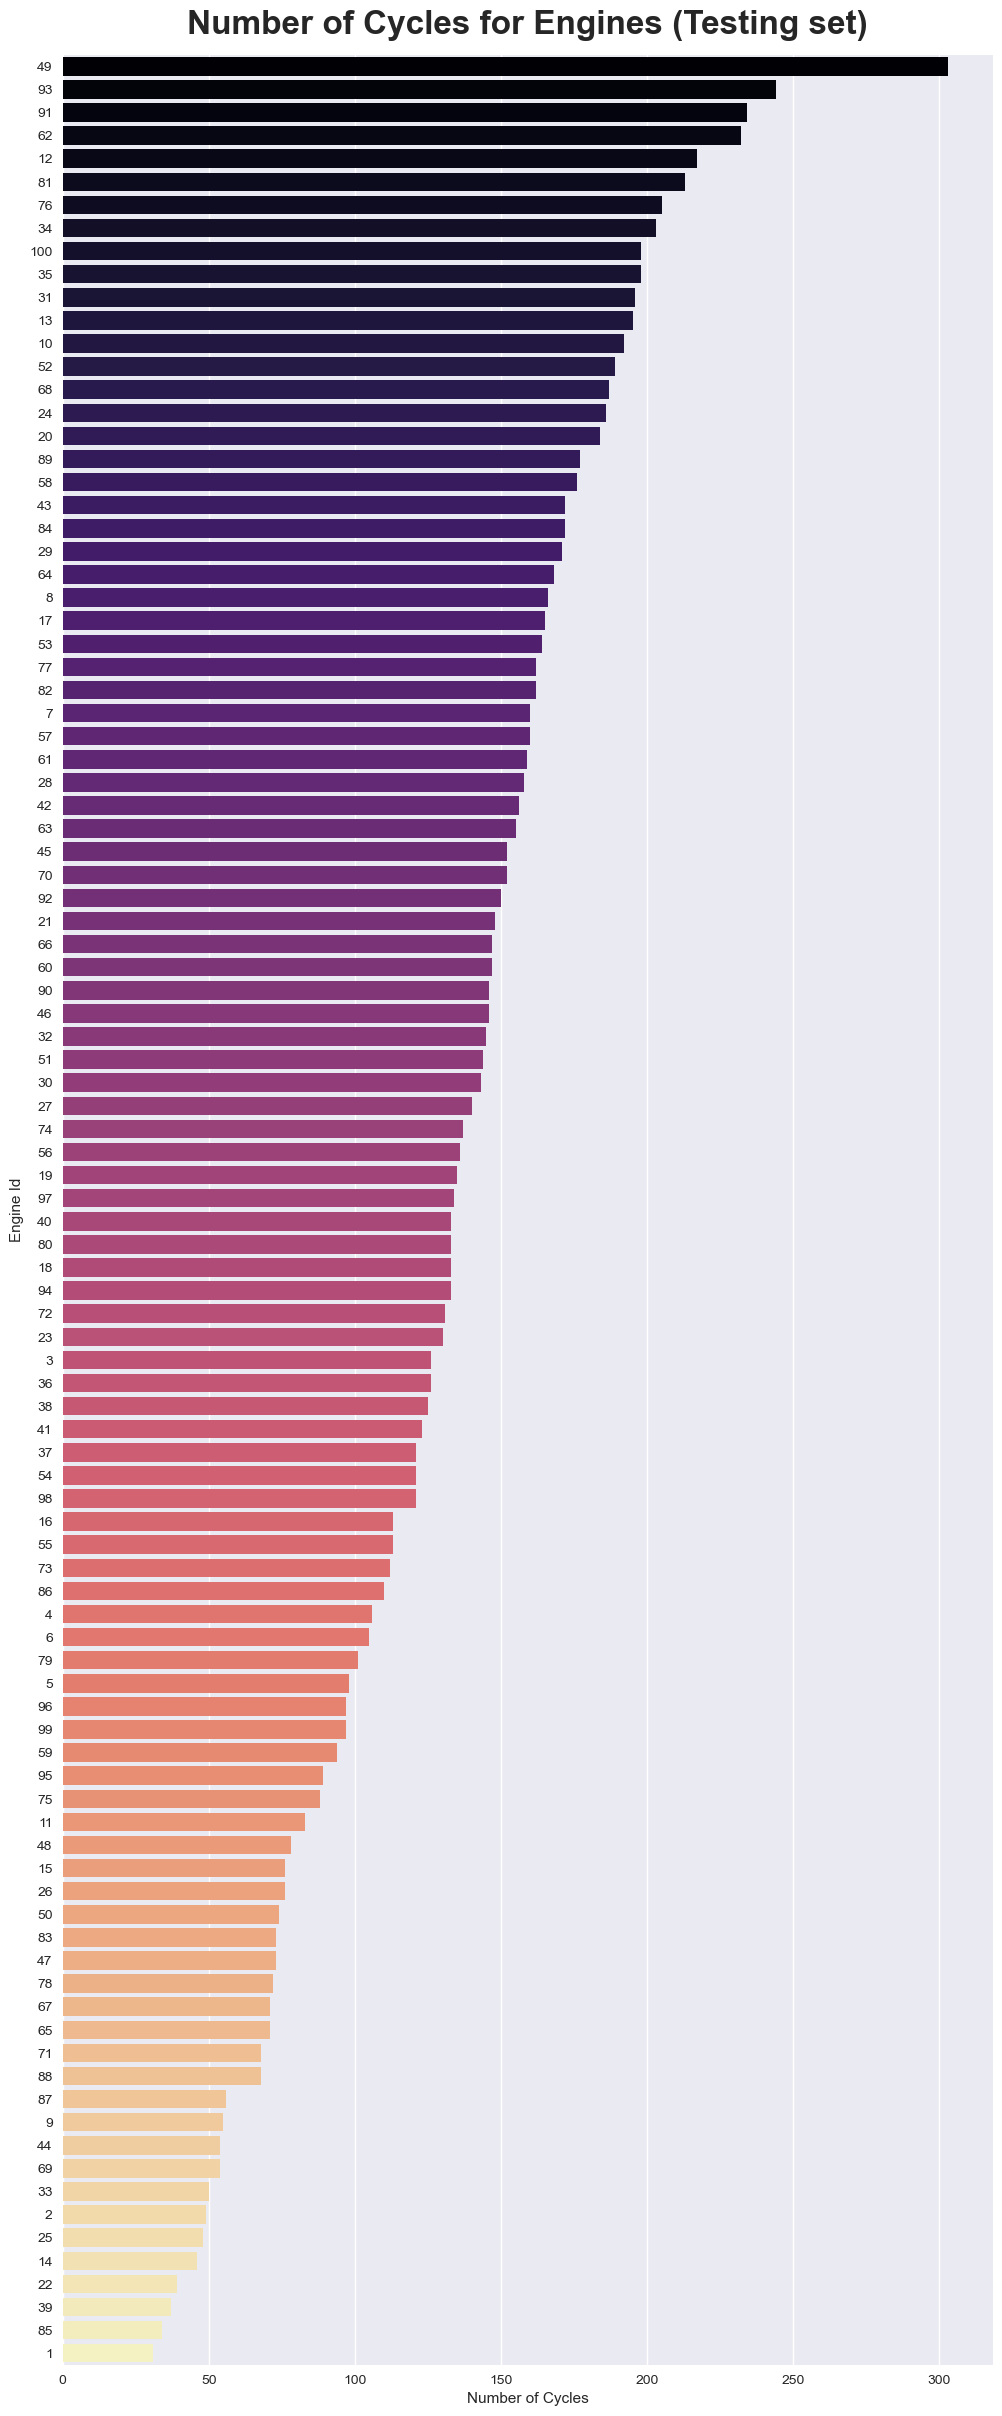

In [22]:
cnt_train = df_test[["id", "cycle"]].groupby("id").max().sort_values(by="cycle", ascending=False)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.cycle.values)

plt.style.use("seaborn")
plt.figure(figsize=(12, 30))
sns.barplot(x=list(cnt_val), y=list(cnt_ind), palette='magma')
plt.xlabel('Number of Cycles')
plt.ylabel('Engine Id')
plt.title('Number of Cycles for Engines (Testing set)', fontweight='bold', fontsize=24, pad=15)

plt.show()




---

1. Engine #49 has value of 303 cicles. It's a maximum value
2. Engine #1 has value of 30 cicles. It's a minimum value

---



In [23]:
period = 30
df_train['label'] = np.where(df_train['rul'] <= period, 1, 0)
df_test['label'] = np.where(df_test['rul'] <= period, 1, 0)
#df_train['label'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
#df_test['label'] = df_test['ttf'].apply(lambda x : 1 if x <= period else 0)
df_train.tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,rul,label
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,0,1


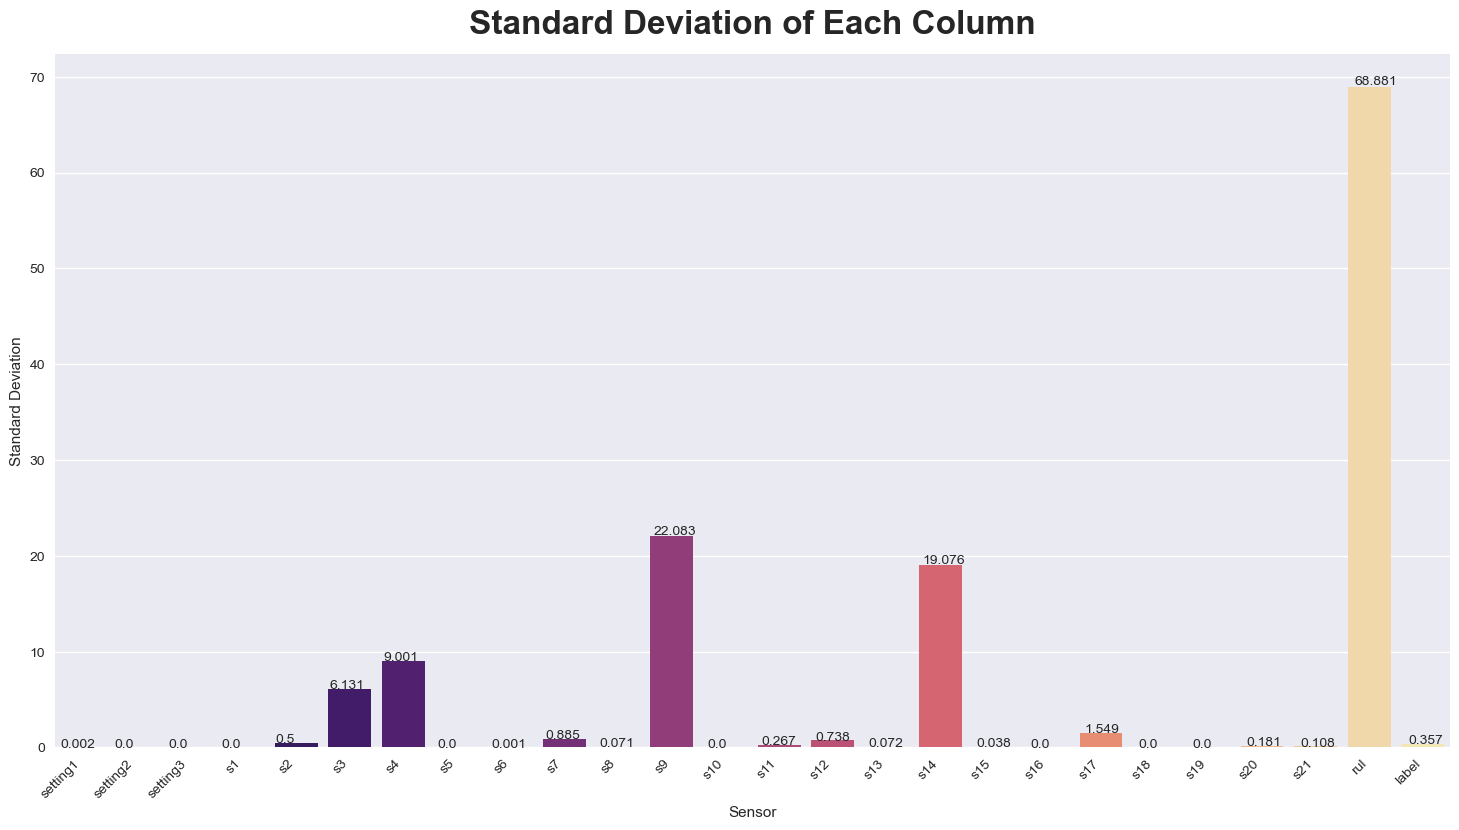

In [24]:
plt.figure(figsize=(18, 9))
subset_stats = df_train.agg(['mean', 'std']).T[2:]
ax = sns.barplot(x=subset_stats.index, y="std", data=subset_stats, palette='magma')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Sensor")
ax.set_ylabel("Standard Deviation")
ax.set_title("Standard Deviation of Each Column", fontweight='bold', fontsize=24, pad=15)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()


In [25]:
std0_cols = list(df_train.std()[(df_train.std() == 0)].index)
std0_cols

['setting3', 's18', 's19']

Удалить константные, дублирующиеся и коррелирующиеся переменные

In [26]:
from corr_selection import correlation
from sklearn.pipeline import Pipeline

from feature_engine.selection import (
    RecursiveFeatureAddition,
    DropConstantFeatures,
    DropDuplicateFeatures,
    DropCorrelatedFeatures,
    RecursiveFeatureElimination
)

In [28]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol = 0.998)),
    ('duplicated', DropDuplicateFeatures()),
    ('correlated', DropCorrelatedFeatures())
])

pipe.fit(df_train)

df_train = pipe.transform(df_train)
df_test = pipe.transform(df_test)

df_train.shape, df_test.shape

((20631, 17), (13096, 17))

In [53]:
df_train.columns

Index(['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's15', 's17', 's20', 's21', 'rul', 'label'],
      dtype='object')

In [29]:
df_train.describe()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s15,s17,s20,s21,rul,label
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,642.680934,1590.523119,1408.933782,21.609803,553.367711,2388.096652,9065.242941,8.442146,393.210654,38.816271,23.289705,107.807862,0.150259
std,29.227633,68.880990,0.002187,0.000293,0.500053,6.131150,9.000605,0.001389,0.885092,0.070985,22.082880,0.037505,1.548763,0.180746,0.108251,68.880990,0.357334
min,1.000000,1.000000,-0.008700,-0.000600,641.210000,1571.040000,1382.250000,21.600000,549.850000,2387.900000,9021.730000,8.324900,388.000000,38.140000,22.894200,0.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,642.325000,1586.260000,1402.360000,21.610000,552.810000,2388.050000,9053.100000,8.414900,392.000000,38.700000,23.221800,51.000000,0.000000
50%,52.000000,104.000000,0.000000,0.000000,642.640000,1590.100000,1408.040000,21.610000,553.440000,2388.090000,9060.660000,8.438900,393.000000,38.830000,23.297900,103.000000,0.000000
75%,77.000000,156.000000,0.001500,0.000300,643.000000,1594.380000,1414.555000,21.610000,554.010000,2388.140000,9069.420000,8.465600,394.000000,38.950000,23.366800,155.000000,0.000000
max,100.000000,362.000000,0.008700,0.000600,644.530000,1616.910000,1441.490000,21.610000,556.060000,2388.560000,9244.590000,8.584800,400.000000,39.430000,23.618400,361.000000,1.000000


In [31]:
df_train.describe()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s15,s17,s20,s21,rul,label
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,642.680934,1590.523119,1408.933782,21.609803,553.367711,2388.096652,9065.242941,8.442146,393.210654,38.816271,23.289705,107.807862,0.150259
std,29.227633,68.880990,0.002187,0.000293,0.500053,6.131150,9.000605,0.001389,0.885092,0.070985,22.082880,0.037505,1.548763,0.180746,0.108251,68.880990,0.357334
min,1.000000,1.000000,-0.008700,-0.000600,641.210000,1571.040000,1382.250000,21.600000,549.850000,2387.900000,9021.730000,8.324900,388.000000,38.140000,22.894200,0.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,642.325000,1586.260000,1402.360000,21.610000,552.810000,2388.050000,9053.100000,8.414900,392.000000,38.700000,23.221800,51.000000,0.000000
50%,52.000000,104.000000,0.000000,0.000000,642.640000,1590.100000,1408.040000,21.610000,553.440000,2388.090000,9060.660000,8.438900,393.000000,38.830000,23.297900,103.000000,0.000000
75%,77.000000,156.000000,0.001500,0.000300,643.000000,1594.380000,1414.555000,21.610000,554.010000,2388.140000,9069.420000,8.465600,394.000000,38.950000,23.366800,155.000000,0.000000
max,100.000000,362.000000,0.008700,0.000600,644.530000,1616.910000,1441.490000,21.610000,556.060000,2388.560000,9244.590000,8.584800,400.000000,39.430000,23.618400,361.000000,1.000000


In [32]:
df_test.describe()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s15,s17,s20,s21,rul,label
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,642.475088,1588.099204,1404.735362,21.609701,553.757523,2388.070964,9058.407363,8.425844,392.571625,38.892502,23.335743,141.238470,0.025351
std,28.289423,53.057749,0.002203,0.000294,0.400899,5.003274,6.688309,0.001704,0.681286,0.057442,11.436261,0.029009,1.233577,0.141681,0.084120,58.980114,0.157196
min,1.000000,1.000000,-0.008200,-0.000600,641.130000,1569.040000,1384.390000,21.600000,550.880000,2387.890000,9024.530000,8.332800,389.000000,38.310000,22.935400,7.000000,0.000000
25%,28.000000,33.000000,-0.001500,-0.000200,642.197500,1584.600000,1399.950000,21.610000,553.310000,2388.030000,9051.020000,8.405600,392.000000,38.800000,23.281600,102.000000,0.000000
50%,52.000000,69.000000,0.000000,0.000000,642.460000,1587.990000,1404.440000,21.610000,553.800000,2388.070000,9057.320000,8.424900,393.000000,38.900000,23.339200,140.000000,0.000000
75%,76.000000,113.000000,0.001500,0.000300,642.740000,1591.362500,1409.050000,21.610000,554.240000,2388.110000,9064.110000,8.444300,393.000000,38.990000,23.393600,179.000000,0.000000
max,100.000000,303.000000,0.007800,0.000700,644.300000,1607.550000,1433.360000,21.610000,555.840000,2388.300000,9155.030000,8.541400,397.000000,39.410000,23.641900,340.000000,1.000000


In [54]:
features_col_name = list(df_train.columns[2:-2])
target_col_name = 'label'


In [55]:
features_col_name

['setting1',
 'setting2',
 's2',
 's3',
 's4',
 's6',
 's7',
 's8',
 's9',
 's15',
 's17',
 's20',
 's21']

In [56]:
scaler = MinMaxScaler()
df_train[features_col_name] = scaler.fit_transform(df_train[features_col_name])
df_test[features_col_name] = scaler.transform(df_test[features_col_name])

In [57]:
df_train.shape

(20631, 17)

## Modelling

In [58]:
def gen_sequence(id_df, seq_length, seq_cols):
  df_zeros = pd.DataFrame(np.zeros((seq_length - 1, id_df.shape[1])), columns = id_df.columns)
  id_df = pd.concat([df_zeros, id_df], ignore_index = True)

  data_array = id_df[seq_cols].values
  num_elements =  data_array.shape[0]
  lstm_array = []

  for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
    lstm_array.append(data_array[start:stop, :])

  return np.array(lstm_array)

In [59]:
def gen_labels(id_df, seq_length, seq_cols, label):
  df_zeros = pd.DataFrame(np.zeros((seq_length - 1, id_df.shape[1])), columns = id_df.columns)
  id_df = pd.concat([df_zeros, id_df], ignore_index = True)

  data_array = id_df[seq_cols].values
  num_elements = data_array.shape[0]
  y_label = []
  for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
    y_label.append(id_df[label][stop])

  return np.array(y_label)

In [60]:
seq_length = 50
seq_cols = features_col_name

In [61]:
X_train = np.concatenate(list(list(gen_sequence(df_train[df_train['id'] == id], seq_length, seq_cols)) for id in df_train['id'].unique()))
print(X_train.shape)
y_train = np.concatenate(list(list(gen_labels(df_train[df_train['id'] == id], seq_length, seq_cols, 'label')) for id in df_train['id'].unique()))
print(y_train.shape)

(20531, 50, 13)
(20531,)


In [62]:
X_test = np.concatenate(list(list(gen_sequence(df_test[df_test['id'] == id], seq_length, seq_cols)) for id in df_test['id'].unique()))
print(X_test.shape)
y_test = np.concatenate(list(list(gen_labels(df_test[df_test['id'] == id], seq_length, seq_cols, 'label')) for id in df_test['id'].unique()))
print(y_test.shape)

(12996, 50, 13)
(12996,)


In [63]:
nb_features = X_train.shape[2]
timestamp = seq_length

model = Sequential()
model.add(LSTM(256, input_shape = (timestamp, nb_features), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128, input_shape = (timestamp, nb_features), return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 256)           276480    
                                                                 
 dropout_2 (Dropout)         (None, 50, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 481,921
Trainable params: 481,921
Non-tr

In [65]:
%%timeit -r 1 -n 1
model.fit(
    X_train,
    y_train,
    epochs = 50,
    batch_size = 20,
    validation_split = 0.2,
    verbose = 1,
    callbacks = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 20, verbose = 1, mode = 'auto')
)

Epoch 1/50
822/822 [==============================] - 111s 130ms/step - loss: 0.1172 - accuracy: 0.9509 - val_loss: 0.1121 - val_accuracy: 0.9537
Epoch 2/50
822/822 [==============================] - 110s 134ms/step - loss: 0.0876 - accuracy: 0.9630 - val_loss: 0.0927 - val_accuracy: 0.9591
Epoch 3/50
822/822 [==============================] - 101s 123ms/step - loss: 0.0803 - accuracy: 0.9647 - val_loss: 0.0775 - val_accuracy: 0.9657
Epoch 4/50
822/822 [==============================] - 95s 115ms/step - loss: 0.0707 - accuracy: 0.9684 - val_loss: 0.0675 - val_accuracy: 0.9703
Epoch 5/50
822/822 [==============================] - 104s 127ms/step - loss: 0.0680 - accuracy: 0.9697 - val_loss: 0.0682 - val_accuracy: 0.9715
Epoch 6/50
822/822 [==============================] - 108s 131ms/step - loss: 0.0647 - accuracy: 0.9711 - val_loss: 0.0622 - val_accuracy: 0.9730
Epoch 7/50
822/822 [==============================] - 104s 126ms/step - loss: 0.0654 - accuracy: 0.9727 - val_loss: 0.0710 - 

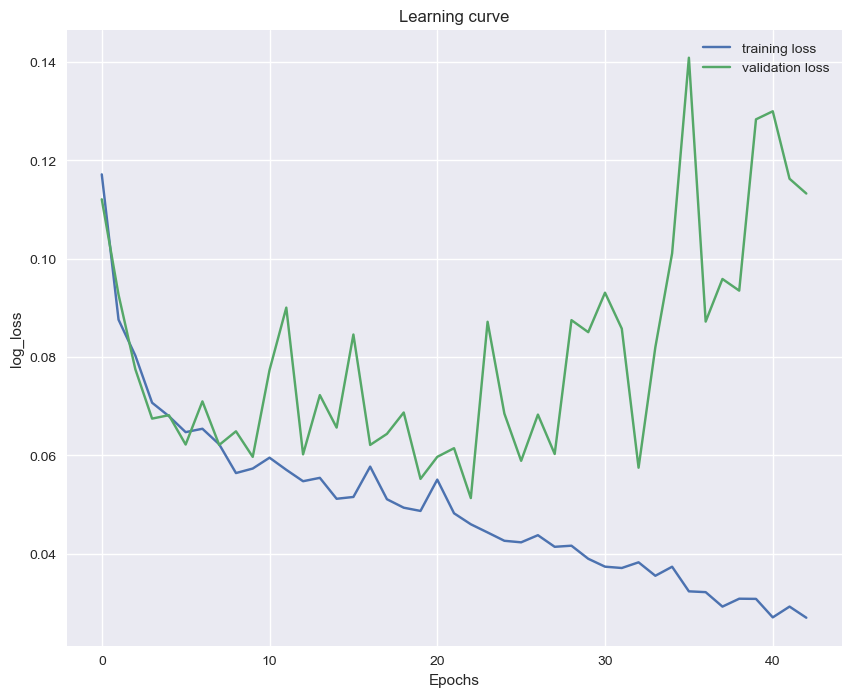

In [66]:
plt.figure(figsize=(10, 8))
plt.title("Learning curve")
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

In [67]:
scores = model.evaluate(X_train, y_train, verbose = 1, batch_size = 20)
print('Accuracy: {}'.format(scores[1]))

1027/1027 [==============================] - 39s 38ms/step - loss: 0.0378 - accuracy: 0.9877
Accuracy: 0.9876771569252014


In [68]:
y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)
print('Accuracy of model on test data: ', accuracy_score(y_test, y_pred))
print('Confusion metrics: \n', confusion_matrix(y_test, y_pred))

407/407 [==============================] - 31s 73ms/step
Accuracy of model on test data:  0.9884579870729455
Confusion metrics: 
 [[12616    48]
 [  102   230]]


In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     12664
         1.0       0.83      0.69      0.75       332

    accuracy                           0.99     12996
   macro avg       0.91      0.84      0.87     12996
weighted avg       0.99      0.99      0.99     12996



In [70]:
def prob_failure(machine_id):
  machine_df = df_test[df_test.id == machine_id]
  machine_test = gen_sequence(machine_df, seq_length, seq_cols)
  m_pred = model.predict(machine_test)
  failure_prob = list(m_pred[-1] * 100)[0]
  return failure_prob

In [71]:
for machine_id in range(1, 101):
  print('Engine_# =', machine_id)
  print('Probability that machine will fail within 30 days: ' + str(prob_failure(machine_id)) + '%')
  print()

Engine_# = 1
1/1 [==============================] - 0s 133ms/step
Probability that machine will fail within 30 days: 7.4603277e-06%

Engine_# = 2
2/2 [==============================] - 0s 43ms/step
Probability that machine will fail within 30 days: 2.977141e-05%

Engine_# = 3
4/4 [==============================] - 0s 87ms/step
Probability that machine will fail within 30 days: 0.5724595%

Engine_# = 4
4/4 [==============================] - 0s 69ms/step
Probability that machine will fail within 30 days: 7.4656295e-05%

Engine_# = 5
4/4 [==============================] - 0s 55ms/step
Probability that machine will fail within 30 days: 3.1907297e-05%

Engine_# = 6
4/4 [==============================] - 0s 66ms/step
Probability that machine will fail within 30 days: 8.728986e-05%

Engine_# = 7
5/5 [==============================] - 0s 76ms/step
Probability that machine will fail within 30 days: 1.4382229e-05%

Engine_# = 8
6/6 [==============================] - 0s 62ms/step
Probability that

Probability that machine will fail within 30 days: 0.0069369003%

Engine_# = 64
6/6 [==============================] - 0s 59ms/step
Probability that machine will fail within 30 days: 95.67396%

Engine_# = 65
3/3 [==============================] - 0s 47ms/step
Probability that machine will fail within 30 days: 8.856014e-06%

Engine_# = 66
5/5 [==============================] - 0s 69ms/step
Probability that machine will fail within 30 days: 99.99885%

Engine_# = 67
3/3 [==============================] - 0s 53ms/step
Probability that machine will fail within 30 days: 1.5372428e-06%

Engine_# = 68
6/6 [==============================] - 0s 68ms/step
Probability that machine will fail within 30 days: 99.99998%

Engine_# = 69
2/2 [==============================] - 0s 40ms/step
Probability that machine will fail within 30 days: 2.3291482e-06%

Engine_# = 70
5/5 [==============================] - 0s 59ms/step
Probability that machine will fail within 30 days: 0.00029027576%

Engine_# = 71
3/3 [

## Conclusion

1) The dataset was presented to us in a training and test sets divided into 2 parts.
The dataset was presented to us in 3 files:
1.	PM_train.txt – Training data
2.	PM_test – Testing data – and
3.  PM_truth – real RUL for testing data

2) Since the training dataset did not contain RUL, they were generated at the feature engineering stage. As for testing set it was merged data from test and truth datasets.

3) We used keras sequential model and RNN LSTM (Long short-term memory). 2 LSTM layers and 2 Dropout layers

4) We used accuracy metric to evaluate our model. The following results were obtained:

Train set - 99.45%

Test set - 99.23%

5) In conclusion, we have displayed the prediction of failure of each engine within the next 30 days.

6) The idea for further improvement of the study: dropping data with null standard diviation in train set.